## En este Notebook, construimos un modelo predictivo usando XGBOOST.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib as mpl
mpl.rcParams['figure.dpi']=400
import xgboost as xgb
from sklearn.metrics import roc_auc_score
import pickle


In [2]:
df=pd.read_csv('df_clean_4.csv')

In [3]:
features_response = df.columns.tolist()

In [4]:
items_to_remove = ['ID', 'PAY_2', 'PAY_3',\
'PAY_4', 'PAY_5', 'PAY_6',\
'EDUCATION_CAT', 'graduate school',\
'high school', 'none',\
'others', 'university']

In [5]:
features_response = [item for item in features_response if item not in
items_to_remove]
features_response

['LIMIT_BAL',
 'SEX',
 'EDUCATION',
 'MARRIAGE',
 'AGE',
 'PAY_1',
 'BILL_AMT1',
 'BILL_AMT2',
 'BILL_AMT3',
 'BILL_AMT4',
 'BILL_AMT5',
 'BILL_AMT6',
 'PAY_AMT1',
 'PAY_AMT2',
 'PAY_AMT3',
 'PAY_AMT4',
 'PAY_AMT5',
 'PAY_AMT6',
 'default payment next month']

In [6]:
X=df[features_response[:-1]].values
y=df[features_response[-1]].values

#### Split in Train/Test

In [7]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test= \
train_test_split(X, y,\
test_size=0.2, random_state=24)

#### Definimos un conjunto de validación para entrenar XGBoost con early stopping, para reducir el overfitting(lo sacamos del mismo conjunto de entrenamiento del split anterior:

In [13]:
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = \
train_test_split(X_train, y_train,\
test_size=0.2, random_state=24)

Instanciamos el modelo:

In [14]:
xgb_model= xgb.XGBClassifier(
n_estimators=1000,
max_depth=0,
learning_rate=0.1,
verbosity=1,
objective='binary:logistic',
use_label_encoder=False,
n_jobs=-1,
tree_method='hist',
grow_policy='lossguide')

optimizaremos sobre el hiperparámetro max_leaves, que controla el numero de hojas en cada árbol.

In [15]:
max_leaves_values = list(range(5,205,5))

Creamos conjunto de evaluación:

In [16]:
eval_set = [(X_train, y_train), (X_val, y_val)]

In [17]:
%%time
val_aucs = []
for max_leaves in max_leaves_values:
#Set parameter and fit model
    xgb_model.set_params(**{'max_leaves':max_leaves})
    xgb_model.fit(X_train, y_train,eval_set=eval_set,eval_metric='auc',verbose=False,early_stopping_rounds=30)
    #Get validation score
    val_set_pred_proba = xgb_model.predict_proba(X_val)[:,1]
    val_aucs.append(roc_auc_score(y_val, val_set_pred_proba))

Wall time: 1min 2s


<AxesSubplot:xlabel='Max leaves'>

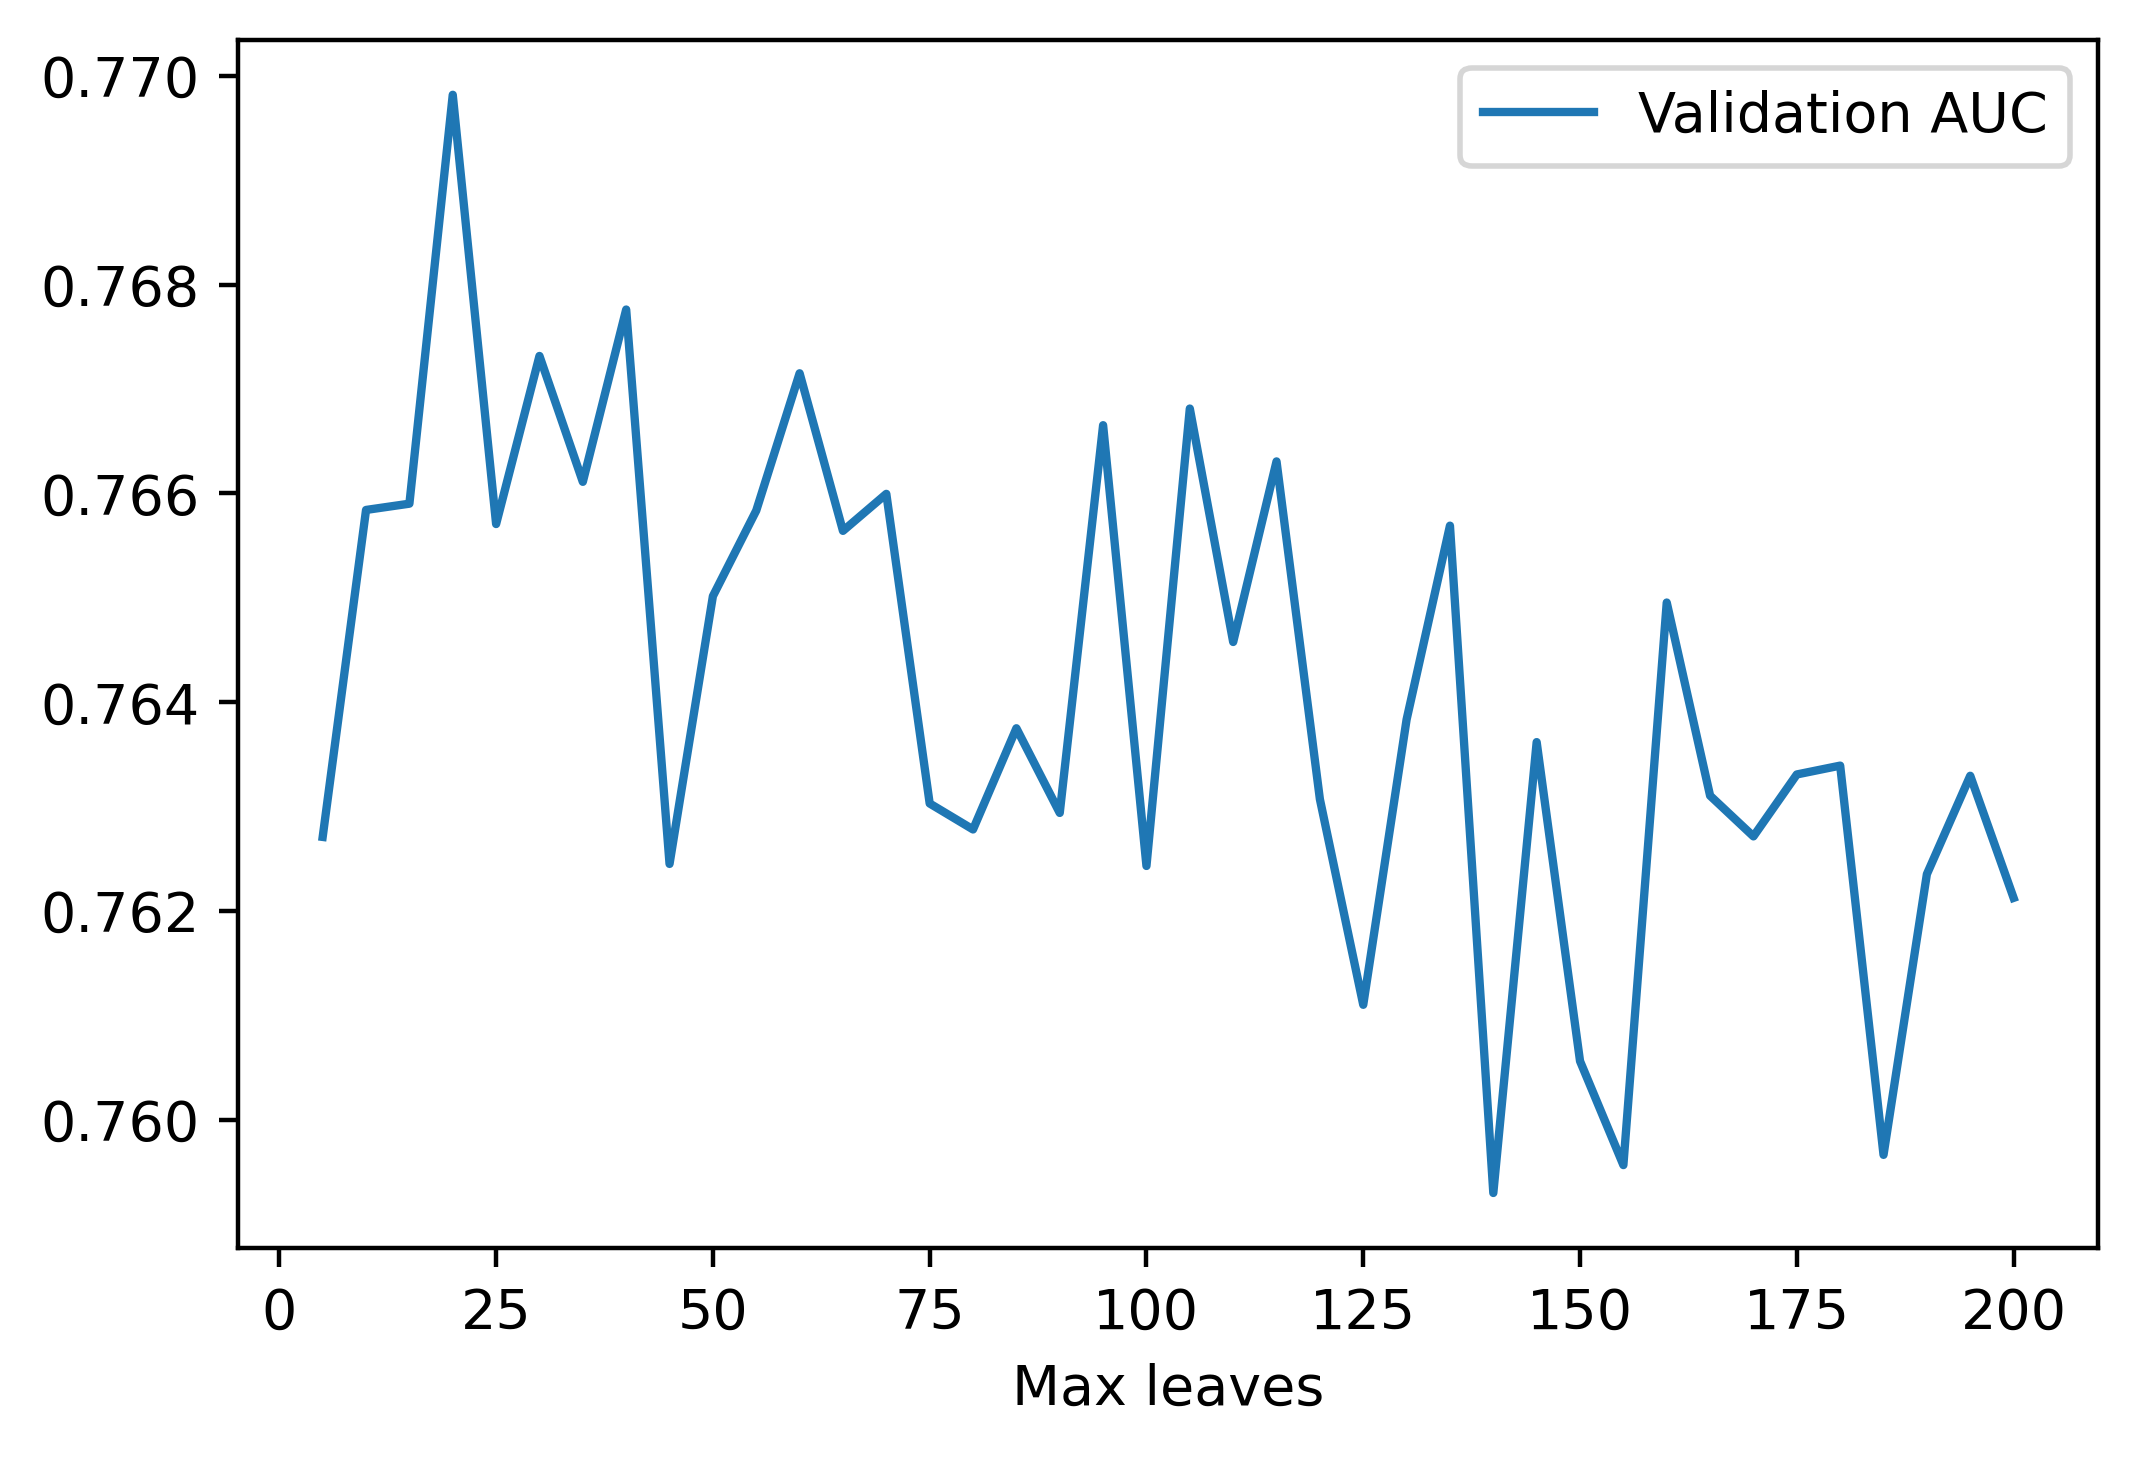

In [18]:
max_leaves_df = \
pd.DataFrame({'Max leaves':max_leaves_values,\
'Validation AUC':val_aucs})
mpl.rcParams['figure.dpi'] = 400
max_leaves_df.set_index('Max leaves').plot()

Although the relationship is somewhat noisy, we see that in general, lower values of max_leaves result in a higher validation
set ROC AUC. This is because limiting the complexity of trees by allowing fewer leaves results in less overfitting, and increases
the validation set score.

Observe the number of max_leaves corresponding to the highest ROC AUC on the validation set:

In [19]:
max_auc = max_leaves_df['Validation AUC'].max()
max_auc
max_ix = max_leaves_df['Validation AUC'] == max_auc
max_leaves_df[max_ix]

,Max leaves,Validation AUC
3,20,0.769817


Reajustamos el modelo con el mejor hiperparámetro:

In [27]:
xgb_model.set_params(**{'max_leaves':20})
xgb_model.fit(X_train, y_train, eval_set=eval_set,
eval_metric='auc',
verbose=False, early_stopping_rounds=30)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              grow_policy='lossguide', importance_type='gain',
              interaction_constraints='', learning_rate=0.1, max_delta_step=0,
              max_depth=0, max_leaves=20, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=1000, n_jobs=-1,
              num_parallel_tree=1, random_state=0, reg_alpha=0, reg_lambda=1,
              scale_pos_weight=1, subsample=1, tree_method='hist',
              use_label_encoder=False, validate_parameters=1, verbosity=1)

In [22]:
with open('xgb_model_w_data.pkl', 'wb') as f:
    pickle.dump([X_train, y_train,X_test, y_test,xgb_model], f)

In [23]:
with open('xgb_model_w_data.pkl', 'rb') as f:
    X_train, y_train, X_test,\
    y_test, xgb_model = pickle.load(f)

In [28]:
test_set_pred_proba = xgb_model.predict_proba(X_test)[:,1]

In [29]:
from sklearn.metrics import roc_auc_score
test_auc = roc_auc_score(y_test, test_set_pred_proba)
test_auc

0.76897280954246

Este es un score más bajo que el que nos dio con Random Forest. Sin duda se puede mejorar haciendo más tuning en los hiperparámetros.